# Experience

In the [tutorial](../tutorials/tutorial_params_options_simulate.ipynb) on `parmas`, `options`, and simulation, we simulated a population of identical individuals: The difference in their behavior was solely due to different random shocks to the reward associated with a choice. In more realistic models, individuals can differ with respect to multiple characteristics, which need to be sampled at the start of the simulation. These characteristics can be:

- **Experience**. Individuals can start with nonzero years of experience for some choice.
- **Lagged choices**. The previous (lagged) choice in the first period can be a subset of all choices in the model.
- **Observables**. An observed characteristic, which does not change over the time-horizon of the model, is not evenly distributed in the population.

Taken together, the assumptions on these characteristics are called the **initial conditions** of a model. An initial condition is also called a seed value and determines the value of a variable in the first period of a dynamic system.

***
In this tutorial we will see how to model heterogeneous initial experience with **respy**: in period $t=0$, Robinson will be allowed to have $0$, $1$, or $2$ periods of experience in fishing. In the baseline Robinson Crusoe economy, experience in fishing directly enters the pecuniary reward from fishing: In period $t$, everything else equal, a Robinson who has already been fishing for $n$ periods will enjoy a higher reward from fishing than a Robinson who has $n^* < n$ periods of experience. 

In more realistic models, agents accumulates educational or on-the-job experience in a similar way. However, in real panel data, individuals are typically not observed since birth, but only after they have accumulated some experience for some choice: failing to account for this heterogeneity in initial experience would result in a misspecified model. This explains why conditioning on initial experience is especially relevant in models of human capital accumulation and occupational choices.

In [1]:
%matplotlib inline

import pandas as pd
import respy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting style
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

## The model: a simple Robinson Crusoe economy, revisited

We revisit the basic Robinson Crusoe economy. In a nutshell, Robinson can choose between fishing and staying in the hammock every period, but he can accumulate experience in **fishing**, which makes him more productive. The pecuniary reward, or wage, from fishing is indeed:

$$
W_{f}=exp\{x_{t}\beta_{f}+ \epsilon_{ft}\}
$$

Up to now we have implicitly assumed that Robinson finds himself in a desert island without any previous experience in fishing: At period 0, each simulated Robinson has experience $x_t$ equal to 0. We want to allow for heterogeneous initial experience in fishing, such that Robinson is allowed to start with different levels of initial experience. 

## Specifications: `params` and `options`

We load the basic model:

In [2]:
params, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

To allow Robinson to have nonzero experience in fishing in the first period, we need to modify `params`: We specify the distribution of initial experience via **probability mass functions**, as the probabilities do not depend on any information. 
The keyword is `"initial_exp_fishing_*"` in the category-level of the index, where the asterisk needs to be replaced with the experience level. In the name-level, use `"probability"` to signal that the float in `"value"` is a probability. 

The new parameter specification is below: Robinson has equal probability to start out with 0, 1 or 2 periods of experience. However, one probability is set to 0.34 so that all probabilities sum to one. If that is not the case, **respy** will emit a warning and normalize probabilities.

In [3]:
params_exp = params.copy()
params_exp.loc[("initial_exp_fishing_0", "probability"), "value"] = 0.33
params_exp.loc[("initial_exp_fishing_1", "probability"), "value"] = 0.33
params_exp.loc[("initial_exp_fishing_2", "probability"), "value"] = 0.34

## Simulation

We can simulate two different datasets to compare Robinson's behavior when we allow for homogeneous or heterogeneous initial experience. By default, Robinson starts with no experience in fishing:

In [4]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [5]:
def plot_choice_probabilities_and_experience_level(df):

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    (
        df.groupby("Period")
        .Choice.value_counts(normalize=True)
        .unstack()
        .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities")
    )

    (
        df.groupby("Period")
        .Experience_Fishing.value_counts(normalize=True)
        .unstack()
        .plot.bar(
            ax=axs[1],
            stacked=True,
            rot=0,
            title="Share of Experience Level per Period",
            cmap="Blues",
        )
    )

    axs[0].legend(
        ["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2
    )
    axs[1].legend(loc="right", bbox_to_anchor=(1.3, 0.5), ncol=1, title="Experience")

    plt.show()

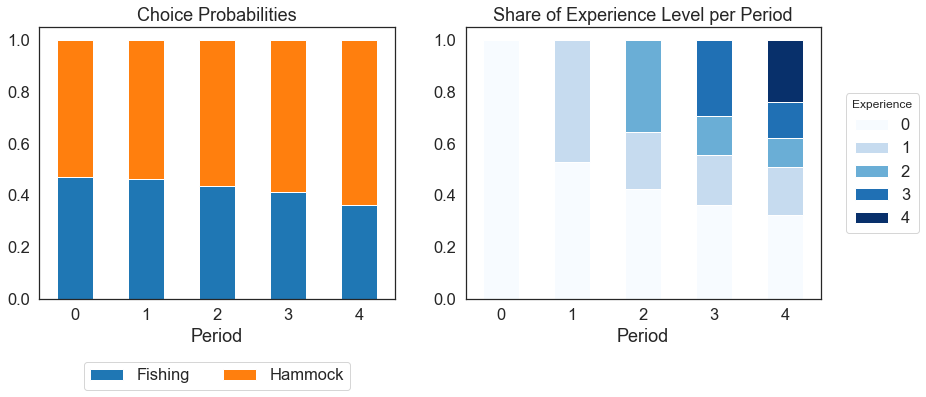

In [6]:
plot_choice_probabilities_and_experience_level(df)

The plots above show Robinson's choice probability and share of experience level by period.

We now allow for heterogeneous experience, with Robinson starting with either 0, 1, or 2 period of experience in fishing: Note that the evolution of Robinson's experience by `"Identifier"` and `"Period"` is reported in the column `"Experience_Fishing"`.

In [7]:
simulate = rp.get_simulate_func(params_exp, options)
df_exp = simulate(params_exp)

In [8]:
df_exp

Experience_Fishing  Shock_Reward_Fishing  \
Identifier Period                                             
0          0                        1             -0.035035   
           1                        2              0.074254   
           2                        3             -0.354560   
           3                        4             -0.109397   
           4                        5             -1.063705   
...                               ...                   ...   
999        0                        2              0.584099   
           1                        3             -0.391274   
           2                        4              0.394125   
           3                        5              0.531008   
           4                        6              1.367302   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.040965   
           1                             1              1.506491   
           2                             1              1.185316   
           3                             1             -0.785877   
           4                             1              1.245234   
...                                    ...                   ...   
999        0                             1              1.611990   
           1                             1              0.371305   
           2                             1             -1.448981   
           3                             1             -0.312350   
           4                             1              1.117095   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           1  fishing   
           1                             1          1           2  fishing   
           2                             1          2           3  fishing   
           3                             1          3           5  fishing   
           4                             1          4           0  hammock   
...                                    ...        ...         ...      ...   
999        0                             1          0           2  fishing   
           1                             1          1           3  fishing   
           2                             1          2           4  fishing   
           3                             1          3           4  fishing   
           4                             1          4           6  fishing   

                        Wage  Discount_Rate  ...  Nonpecuniary_Reward_Fishing  \
Identifier Period                            ...                                
0          0        1.326418           0.95  ...                         -0.2   
           1        1.891040           0.95  ...                         -0.2   
           2        2.060029           0.95  ...                         -0.2   
           3        3.143388           0.95  ...                         -0.2   
           4             NaN           0.95  ...                         -0.2   
...                      ...            ...  ...                          ...   
999        0        2.440126           0.95  ...                         -0.2   
           1        2.022558           0.95  ...                         -0.2   
           2        4.043305           0.95  ...                         -0.2   
           3        5.844517           0.95  ...                         -0.2   
           4       11.984942           0.95  ...                         -0.2   

                   Wage_Fishing  Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                               
0          0           1.326418              1.126418               12.326832   
  

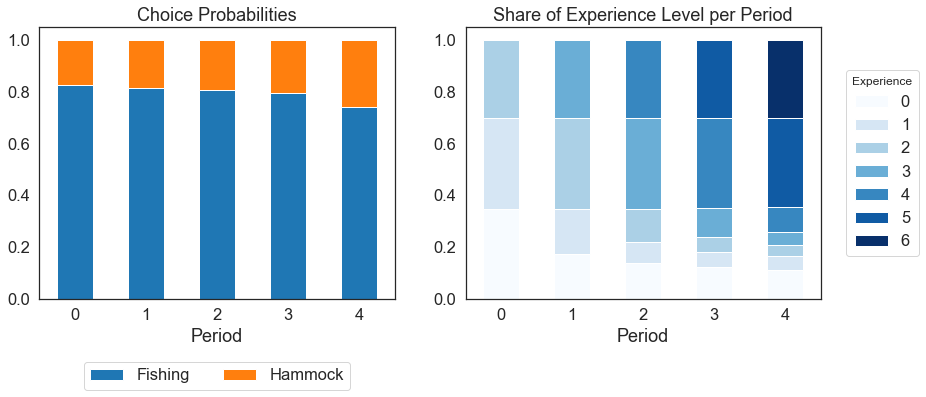

In [9]:
plot_choice_probabilities_and_experience_level(df_exp)

Robinson is now more likely to fish in each period and can achieve up to seven period of experience in fishing (if he starts with $2$ periods of experience and always chooses fishing). The intuition is that, in the very first period, the Robinsons who start with a nonzero experience in fishing earns a higher **pecuniary reward** from fishing, and therefore are more likely to choose this option with respect to those who start with no experience. If they do, the same intuition holds for the next period, and so on. 

Below, we inspect the share of experience level by period conditional on experience level.

In [10]:
def plot_conditional_choice_probabilities_and_experience_level(df):

    fig, axs = plt.subplots(3, 2, figsize=(14, 15))

    axs = axs.flatten()

    plt.subplots_adjust(hspace=0.5)

    for initial_experience, i in enumerate([0, 2, 4]):
        identifiers = (
            df.query("Experience_Fishing == @initial_experience and Period == 0")
            .index.get_level_values("Identifier")
            .values
        )
        (
            df.loc[identifiers]
            .groupby("Period")
            .Choice.value_counts(normalize=True)
            .unstack()
            .plot.bar(
                width=0.4,
                stacked=True,
                rot=0,
                ax=axs[i],
                title="Initial Fishing Experience: " + str(initial_experience),
                legend=False,
            )
        )

        (
            df.loc[identifiers]
            .groupby("Period")
            .Experience_Fishing.value_counts(normalize=True)
            .unstack()
            .plot.bar(
                ax=axs[i + 1],
                stacked=True,
                rot=0,
                title="Share of Experience Level per Period",
                color=sns.color_palette("Blues", 7)[initial_experience:],
                legend=False,
            )
        )
        axs[i+1].legend(loc="right", bbox_to_anchor=(1.3, 0.5), ncol=1, title="Experience")

    axs[4].legend(
        ["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2
    )

    plt.suptitle("Robinson's choices by period", y=0.95)

    plt.show()

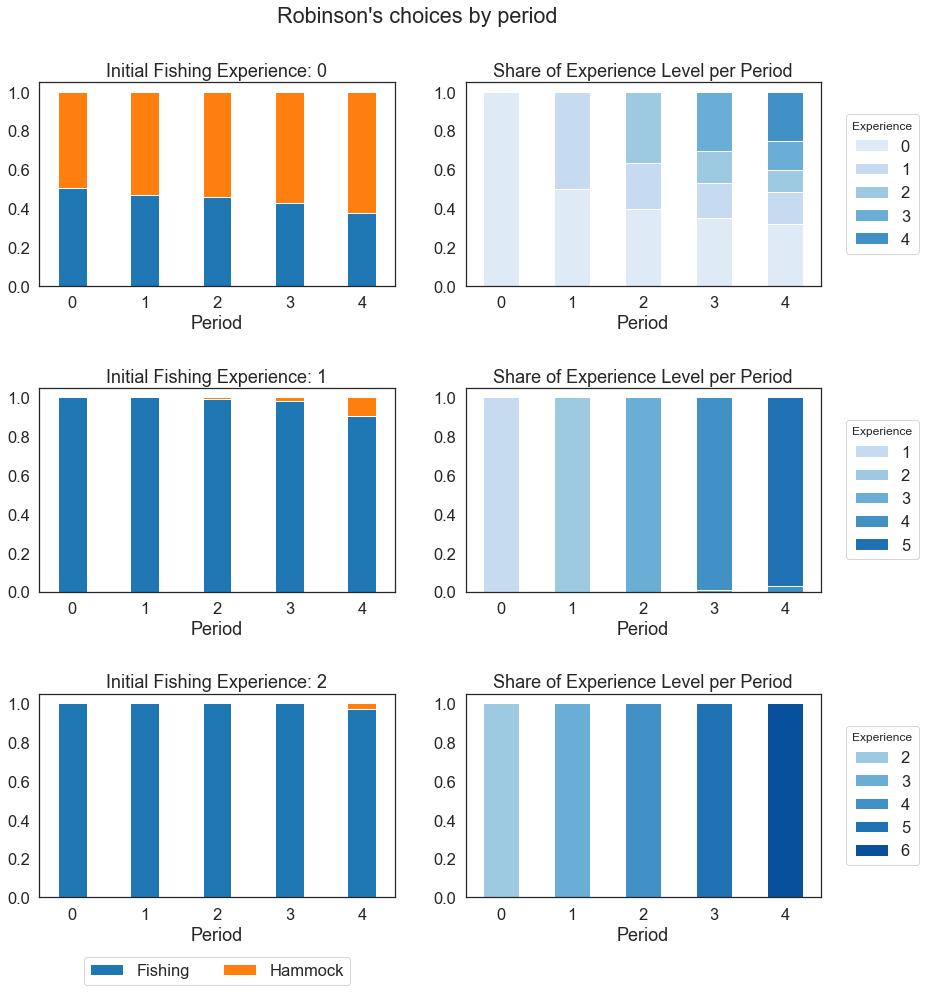

In [11]:
plot_conditional_choice_probabilities_and_experience_level(df_exp)

Indeed, the Robinsons who have nonzero initial experience in fishing choose fishing virtually every period. 

In general, however, choice probabilities need not dramatically differ conditional on initial experience. In the example below, the return to experience in fishing is $0.1$, compared to $0.3$ in the basic model we have simulated above, which makes fishing less attractive compared to relaxing on the hammock. 

As a result, the conditional choice probabilities are not as affected by initial experience: Individuals with nonzero initial experience gain a higher wage from fishing than those with no initial experience, but choosing the hammock is preferred anyways, as the return to experience in fishing is so low. 

In [12]:
params_exp.loc[("wage_fishing", "exp_fishing"), "value"] = 0.10

In [13]:
simulate = rp.get_simulate_func(params_exp, options)
df_exp = simulate(params_exp)

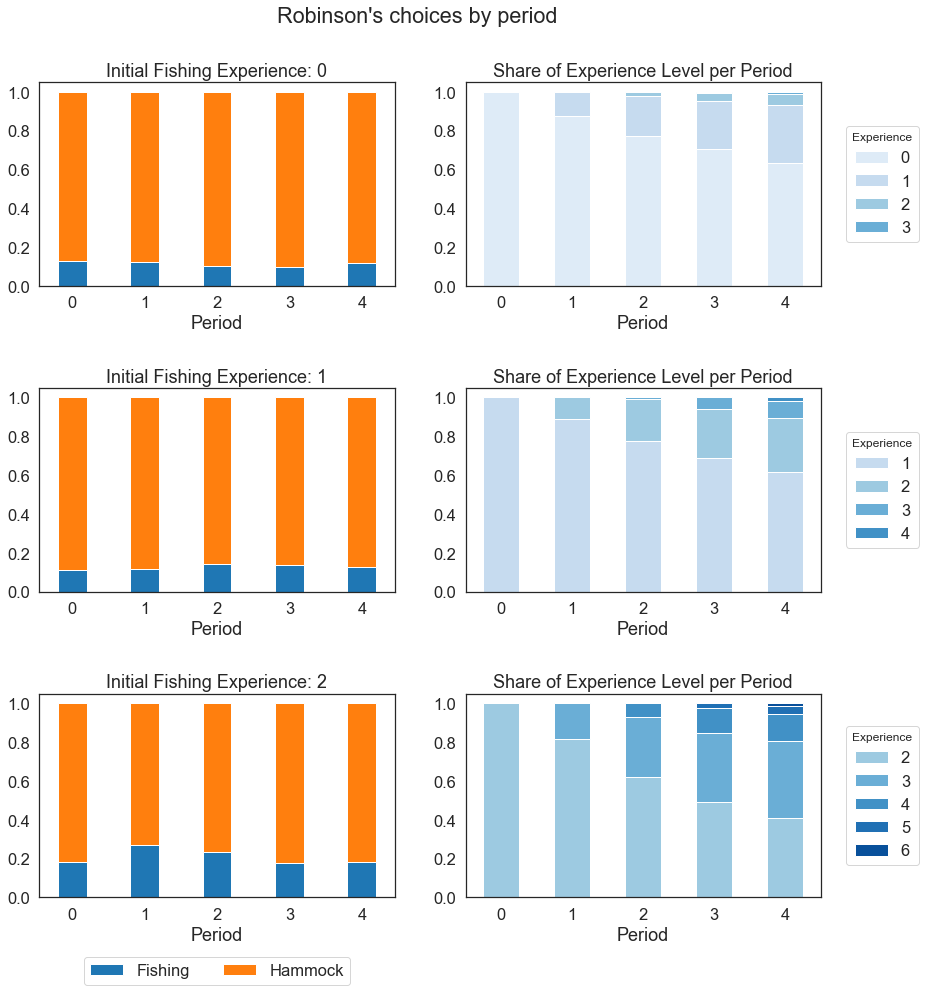

In [14]:
plot_conditional_choice_probabilities_and_experience_level(df_exp)